Epoch 1/50
20/20 [==============================] - 2s 21ms/step - loss: 0.2646 - val_loss: 0.1634
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0782 - val_loss: 0.0293
Epoch 3/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0256 - val_loss: 0.0255
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0224 - val_loss: 0.0265
Epoch 5/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0228 - val_loss: 0.0243
Epoch 6/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0218 - val_loss: 0.0238
Epoch 7/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0215 - val_loss: 0.0229
Epoch 8/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0211 - val_loss: 0.0222
Epoch 9/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0207 - val_loss: 0.0214
Epoch 10/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.0208
Epoch 11/50
20/20 

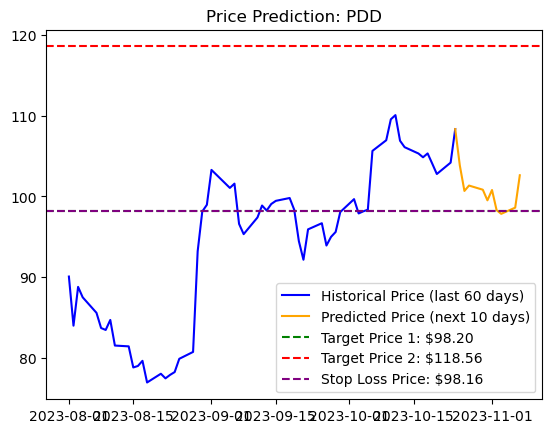

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from datetime import datetime

# 下载股票数据
ticker_symbol = 'PDD'  # 股票代码
ticker_data = yf.Ticker(ticker_symbol)
historical_data = ticker_data.history(period='12mo')  # 只考虑最近12个月的数据
data = historical_data[['Close', 'Volume']]  # 使用收盘价和成交量

# 数据归一化
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)  # 数据归一化，方便模型训练

# 准备输入数据
X = data_scaled[:-10]  # 使用除最后10天的数据作为输入
y = data_scaled[10:, 0]  # 预测未来10天的收盘价作为输出
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)  # 划分训练集和测试集

# 创建和训练LSTM模型
model_lstm = Sequential()
model_lstm.add(LSTM(100, input_shape=(X_train.shape[1], 1)))  # LSTM层，100个单元
model_lstm.add(Dense(1))  # 输出层，1个单元
model_lstm.compile(optimizer='adam', loss='mean_squared_error')  # 使用adam优化器和均方误差损失函数
model_lstm.fit(X_train[:, :, np.newaxis], y_train, epochs=50, batch_size=10, validation_data=(X_test[:, :, np.newaxis], y_test), verbose=1, shuffle=False)  # 训练模型

# 创建和训练线性回归模型
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)  # 训练模型

# 创建和训练随机森林模型
model_rf = RandomForestRegressor(n_estimators=100, random_state=12)  # 随机森林模型，100棵树
model_rf.fit(X_train, y_train)  # 训练模型

# 集成预测
lstm_predict = model_lstm.predict(data_scaled[-10:, :, np.newaxis])[:, 0]  # LSTM模型预测
lr_predict = model_lr.predict(data_scaled[-10:])  # 线性回归模型预测
rf_predict = model_rf.predict(data_scaled[-10:])  # 随机森林模型预测
ensemble_predict = (lstm_predict + lr_predict + rf_predict) / 3  # 平均集成预测

# 反归一化预测结果
predicted_prices = scaler.inverse_transform(np.hstack([ensemble_predict.reshape(-1, 1), np.zeros((10, 1))]))[:, 0]  # 反归一化得到原始预测价格

# 寻找过去密集区的中位数价格并确定目标价1
for days in [60, 120, 180]:
    past_data = historical_data['Close'].iloc[-days:]
    price_bins = np.linspace(past_data.min(), past_data.max(), 100)
    price_freq, _ = np.histogram(past_data, bins=price_bins)
    densely_packed_areas_mid_prices = [(price_bins[i] + price_bins[i+1]) / 2 for i in np.argsort(price_freq)[::-1][:3]]
    target_price_1_candidates = [price for price in densely_packed_areas_mid_prices if predicted_prices.min() <= price <= predicted_prices.max()]
    if target_price_1_candidates:
        target_price_1 = min(target_price_1_candidates, key=lambda x: abs(x - predicted_prices.max()))  # 选择离预测最高价最近的作为目标价1
        break
else:  # 如果在过去的数据中没有找到合适的目标价1，则基于最近5天的涨幅百分比来计算目标价1
    recent_growth_rate = (data['Close'].iloc[-1] - data['Close'].iloc[-6]) / data['Close'].iloc[-6]
    target_price_1 = data['Close'].iloc[-1] + recent_growth_rate * (data['Close'].iloc[-1] - data['Close'].iloc[-6])

# 确定目标价2和止损价
target_price_2 = predicted_prices.max()  # 预测价格的最高点作为目标价2
stop_loss_price = historical_data['Close'].iloc[-15:].min()  # 最近15天的最低价作为止损价
# 如果目标价2小于或等于目标价1，或者风险收益比不合理，则调整目标价2和止损价
max_iterations = 10  # 设置最大迭代次数以避免无限循环
iterations = 0  # 初始化迭代计数器
while (target_price_2 <= target_price_1 or 
       (target_price_1 - data['Close'].values[-1]) / (data['Close'].values[-1] - stop_loss_price) < 2) and iterations < max_iterations:
    target_price_2 = max(target_price_2, target_price_1 + 2 * (data['Close'].values[-1] - stop_loss_price))  # 调整目标价2以保证风险收益比
    stop_loss_price = min(stop_loss_price, data['Close'].values[-1] - (target_price_1 - data['Close'].values[-1]) / 2)  # 调整止损价以保证风险收益比
    iterations += 1  # 更新迭代计数器

# 绘图
fig, ax = plt.subplots()
# 绘制最近60天的历史价格
ax.plot(data.index[-60:], data['Close'].values[-60:], label='Historical Price (last 60 days)', color='blue')  # 最近60天的历史价格

# 未来10个交易日的日期
future_dates = pd.date_range(start=data.index[-1] + BDay(1), periods=10, freq='B')  # 未来10个交易日的日期

# 连接最后一天的历史价格和第一天的预测价格
connected_dates = data.index[-1:].append(future_dates)  # 连接日期
connected_prices = np.concatenate((data['Close'].values[-1:], predicted_prices))  # 连接价格

# 绘制预测价格
ax.plot(connected_dates, connected_prices, label='Predicted Price (next 10 days)', color='orange')  # 预测价格

# 绘制目标价和止损价
ax.axhline(y=target_price_1, color='green', linestyle='--', label=f'Target Price 1: ${target_price_1:.2f}')
ax.axhline(y=target_price_2, color='red', linestyle='--', label=f'Target Price 2: ${target_price_2:.2f}')
ax.axhline(y=stop_loss_price, color='purple', linestyle='--', label=f'Stop Loss Price: ${stop_loss_price:.2f}')

ax.legend()
plt.title(f'Price Prediction: {ticker_symbol}')
plt.show()


In [6]:
 import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from datetime import datetime

# 下载股票数据
ticker_symbol = 'PDD'  # 股票代码
ticker_data = yf.Ticker(ticker_symbol)
historical_data = ticker_data.history(period='12mo')  # 只考虑最近12个月的数据
data = historical_data[['Close', 'Volume']]  # 使用收盘价和成交量

# 数据归一化
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)  # 数据归一化，方便模型训练

# 准备输入数据
X = data_scaled[:-10]  # 使用除最后10天的数据作为输入
y = data_scaled[10:, 0]  # 预测未来10天的收盘价作为输出
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)  # 划分训练集和测试集

# 创建和训练LSTM模型
model_lstm = Sequential()
model_lstm.add(LSTM(100, input_shape=(X_train.shape[1], 1)))  # LSTM层，100个单元
model_lstm.add(Dense(1))  # 输出层，1个单元
model_lstm.compile(optimizer='adam', loss='mean_squared_error')  # 使用adam优化器和均方误差损失函数
model_lstm.fit(X_train[:, :, np.newaxis], y_train, epochs=50, batch_size=10, validation_data=(X_test[:, :, np.newaxis], y_test), verbose=1, shuffle=False)  # 训练模型

# 创建和训练线性回归模型
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)  # 训练模型

# 创建和训练随机森林模型
model_rf = RandomForestRegressor(n_estimators=100, random_state=12)  # 随机森林模型，100棵树
model_rf.fit(X_train, y_train)  # 训练模型

# 集成预测
lstm_predict = model_lstm.predict(data_scaled[-10:, :, np.newaxis])[:, 0]  # LSTM模型预测
lr_predict = model_lr.predict(data_scaled[-10:])  # 线性回归模型预测
rf_predict = model_rf.predict(data_scaled[-10:])  # 随机森林模型预测
ensemble_predict = (lstm_predict + lr_predict + rf_predict) / 3  # 平均集成预测

# 反归一化预测结果
predicted_prices = scaler.inverse_transform(np.hstack([ensemble_predict.reshape(-1, 1), np.zeros((10, 1))]))[:, 0]  # 反归一化得到原始预测价格
predicted_prices

Epoch 1/50
20/20 [==============================] - 2s 20ms/step - loss: 0.2868 - val_loss: 0.1807
Epoch 2/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0884 - val_loss: 0.0332
Epoch 3/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0265 - val_loss: 0.0266
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0226 - val_loss: 0.0274
Epoch 5/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0230 - val_loss: 0.0252
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0220 - val_loss: 0.0245
Epoch 7/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0217 - val_loss: 0.0236
Epoch 8/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0212 - val_loss: 0.0227
Epoch 9/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0208 - val_loss: 0.0219
Epoch 10/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0204 - val_loss: 0.0212
Epoch 11/50
20/20 

array([103.82502741, 100.6729172 , 101.34606951, 100.83079622,
        99.51536473, 100.79512365,  98.29311995,  97.84633389,
        98.60882857, 102.61342061])

In [11]:
print('LSTM模型预测', lstm_predict)  

print('线性回归模型预测',lr_predict)  

print('随机森林模型预测',rf_predict)


LSTM模型预测 [0.91548634 0.87369263 0.8684514  0.85801584 0.850301   0.8577878
 0.8395614  0.8252867  0.84078485 0.8892717 ]
线性回归模型预测 [0.895807   0.85919279 0.85360184 0.84443844 0.83789207 0.84430164
 0.82845365 0.81531298 0.8296003  0.87354197]
随机森林模型预测 [0.88913972 0.81634312 0.85946593 0.85434761 0.80550846 0.85300127
 0.76705628 0.77303965 0.77983051 0.87949949]


In [12]:
# 将预测结果重塑为正确的形状
lstm_predict_reshaped = lstm_predict.reshape(-1, 1)
lr_predict_reshaped = lr_predict.reshape(-1, 1)
rf_predict_reshaped = rf_predict.reshape(-1, 1)

# 创建一个与原始数据相同形状的零数组
zeros_array = np.zeros((len(lstm_predict), 1))

# 将预测结果和零数组连接起来以匹配原始数据的形状
lstm_data_for_inverse = np.hstack([lstm_predict_reshaped, zeros_array])
lr_data_for_inverse = np.hstack([lr_predict_reshaped, zeros_array])
rf_data_for_inverse = np.hstack([rf_predict_reshaped, zeros_array])

# 使用scaler的inverse_transform方法进行反归一化
lstm_prices = scaler.inverse_transform(lstm_data_for_inverse)[:, 0]
lr_prices = scaler.inverse_transform(lr_data_for_inverse)[:, 0]
rf_prices = scaler.inverse_transform(rf_data_for_inverse)[:, 0]


In [14]:
print('LSTM模型预测', lstm_prices)  

print('线性回归模型预测',lr_prices)  

print('随机森林模型预测',rf_prices)

LSTM模型预测 [104.78451506 102.17073677 101.84295116 101.1903099  100.7078258
 101.17604782 100.03616968  99.1434289  100.11268393 103.14505024]
线性回归模型预测 [103.55376954 101.26391663 100.91425845 100.34117987  99.93176973
 100.3326243   99.3414908   98.51967348  99.4132025  102.16131418]
随机森林模型预测 [103.13679764  98.58409821 101.28099892 100.9608989   97.90649864
 100.87669884  95.50169937  95.87589928  96.30059929 102.5338974 ]


Epoch 1/50
35/35 [==============================] - 4s 60ms/step - loss: 0.0465 - val_loss: 0.0072
Epoch 2/50
35/35 [==============================] - 2s 53ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 3/50
35/35 [==============================] - 2s 53ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 4/50
35/35 [==============================] - 2s 54ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 5/50
35/35 [==============================] - 2s 54ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 6/50
35/35 [==============================] - 2s 54ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 7/50
35/35 [==============================] - 2s 54ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 8/50
35/35 [==============================] - 2s 54ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 9/50
35/35 [==============================] - 2s 54ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 10/50
35/35 [==============================] - 2s 54ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 11/

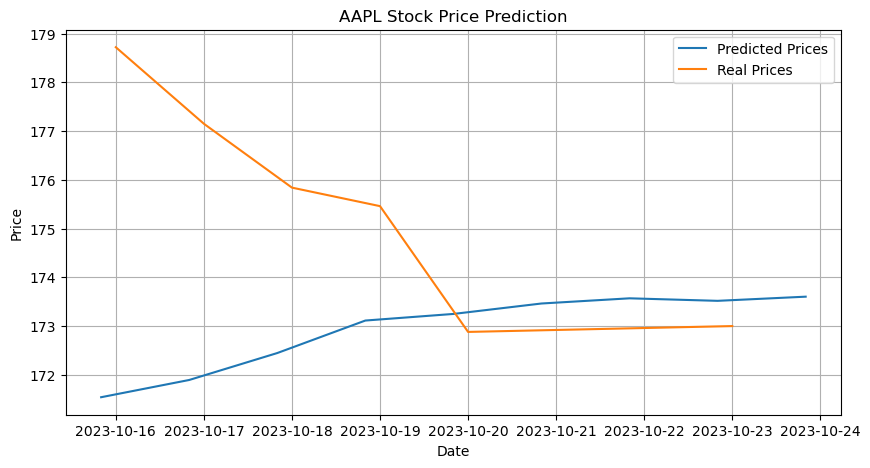

In [20]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import datetime

# 下载股票数据
ticker_symbol = 'AAPL'  # 股票代码
ticker_data = yf.Ticker(ticker_symbol)
historical_data = ticker_data.history(start='2022-01-01', end='2023-10-01')  # 使用2022年1月1日至2023年10月1日的数据
data = historical_data[['Close', 'Volume']]  # 使用收盘价和成交量

# 数据归一化
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)  # 数据归一化，方便模型训练

# 准备输入数据
X = data_scaled[:-1]  # 使用除最后1天的数据作为输入
y = data_scaled[1:, 0]  # 预测未来1天的收盘价作为输出
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)  # 划分训练集和测试集

# 创建和训练LSTM模型
model_lstm = Sequential()
model_lstm.add(LSTM(1000, input_shape=(X_train.shape[1], 1)))  # LSTM层，100个单元
model_lstm.add(Dense(1))  # 输出层，1个单元
model_lstm.compile(optimizer='adam', loss='mean_squared_error')  # 使用adam优化器和均方误差损失函数
model_lstm.fit(X_train[:, :, np.newaxis], y_train, epochs=50, batch_size=10, validation_data=(X_test[:, :, np.newaxis], y_test), verbose=1, shuffle=False)  # 训练模型

# 创建和训练线性回归模型
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)  # 训练模型

# 创建和训练随机森林模型
model_rf = RandomForestRegressor(n_estimators=1000, random_state=42)  # 随机森林模型，100棵树
model_rf.fit(X_train, y_train)  # 训练模型

# 从2023年10月1日开始预测至今天
current_date = datetime(2023, 10, 16)
end_date = datetime.now()
prediction_dates = pd.date_range(start=current_date, end=end_date)
predicted_prices = []

for i in range(len(prediction_dates)):
    input_data = data_scaled[-1].reshape(1, -1)  # 使用最近的数据作为输入
    lstm_predict = model_lstm.predict(input_data[:, :, np.newaxis])[0, 0]  # LSTM模型预测
    lr_predict = model_lr.predict(input_data)[0]  # 线性回归模型预测
    rf_predict = model_rf.predict(input_data)[0]  # 随机森林模型预测
    ensemble_predict = (lstm_predict + lr_predict + rf_predict) / 3  # 平均集成预测
    #ensemble_predict =  lstm_predict
    
    predicted_prices.append(ensemble_predict)
    # 更新输入数据以包括新的预测
    new_data_point = np.array([[ensemble_predict, 0]])  # 假设新预测的交易量为0
    data_scaled = np.concatenate((data_scaled, new_data_point), axis=0)

# 反归一化预测结果
predicted_prices_array = np.array(predicted_prices).reshape(-1, 1)
predicted_prices_reshaped = np.hstack([predicted_prices_array, np.zeros((len(predicted_prices_array), 1))])
predicted_prices_final = scaler.inverse_transform(predicted_prices_reshaped)[:, 0]

# 获取真实股价数据
real_data = ticker_data.history(start='2023-10-16', end=end_date.strftime('%Y-%m-%d'))
real_prices = real_data['Close'].values

# 绘图
plt.figure(figsize=(10, 5))
plt.plot(prediction_dates, predicted_prices_final, label='Predicted Prices')
plt.plot(real_data.index, real_prices, label='Real Prices')
plt.legend()
plt.title(f'{ticker_symbol} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


Epoch 1/50
15/15 [==============================] - 2s 26ms/step - loss: 0.3532 - val_loss: 0.1593
Epoch 2/50
15/15 [==============================] - 0s 4ms/step - loss: 0.1590 - val_loss: 0.0601
Epoch 3/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0434 - val_loss: 0.0647
Epoch 4/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0382 - val_loss: 0.0641
Epoch 5/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0332 - val_loss: 0.0505
Epoch 6/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0298 - val_loss: 0.0503
Epoch 7/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0286 - val_loss: 0.0492
Epoch 8/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0273 - val_loss: 0.0459
Epoch 9/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0258 - val_loss: 0.0438
Epoch 10/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0247 - val_loss: 0.0419
Epoch 11/50
15/15 

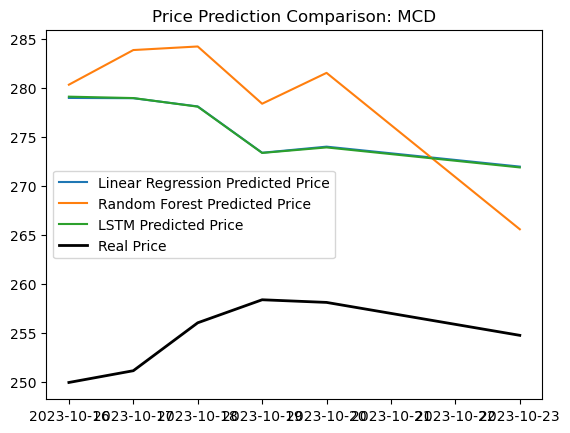

In [22]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import datetime

# 下载股票数据
ticker_symbol = 'MCD'  # 股票代码
ticker_data = yf.Ticker(ticker_symbol)
start_date = '2023-01-01'
end_date = '2023-10-01'
historical_data = ticker_data.history(start=start_date, end=end_date)
data = historical_data[['Close', 'Volume']]  # 使用收盘价和成交量

# 数据归一化
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)  # 数据归一化，方便模型训练

# 准备输入数据
X = data_scaled[:-10]  # 使用除最后10天的数据作为输入
y = data_scaled[10:, 0]  # 预测未来10天的收盘价作为输出
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)  # 划分训练集和测试集

# 创建和训练模型
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=12),
    "LSTM": Sequential([
        LSTM(100, input_shape=(X_train.shape[1], 1)),  # LSTM层，100个单元
        Dense(1)  # 输出层，1个单元
    ])
}
models["LSTM"].compile(optimizer='adam', loss='mean_squared_error')  # 使用adam优化器和均方误差损失函数

# 训练模型
models["Linear Regression"].fit(X_train, y_train)
models["Random Forest"].fit(X_train, y_train)
models["LSTM"].fit(X_train[:, :, np.newaxis], y_train, epochs=50, batch_size=10, validation_data=(X_test[:, :, np.newaxis], y_test), verbose=1, shuffle=False)

# 获取真实的股价数据
real_data = ticker_data.history(start='2023-10-16', end=datetime.today().strftime('%Y-%m-%d'))
real_prices = real_data['Close'].values

# 获取数据点的数量
num_points = min(len(real_prices), 10)

# 预测股价
predictions = {}
for model_name, model in models.items():
    if model_name == "LSTM":
        predictions[model_name] = model.predict(data_scaled[-10:, :, np.newaxis])[:, 0]
    else:
        predictions[model_name] = model.predict(data_scaled[-10:])
    predicted_prices = scaler.inverse_transform(np.hstack([predictions[model_name][:num_points].reshape(-1, 1), np.zeros((num_points, 1))]))[:, 0]
    plt.plot(real_data.index, predicted_prices, label=f'{model_name} Predicted Price')

# 绘制真实股价
plt.plot(real_data.index, real_prices, label='Real Price', color='black', linewidth=2)

plt.legend()
plt.title(f'Price Prediction Comparison: {ticker_symbol}')
plt.show()


Epoch 1/50
74/74 [==============================] - 5s 20ms/step - loss: 0.0202 - val_loss: 0.0019
Epoch 2/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 3/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 4/50
74/74 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 5/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 6/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 7/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 8/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 9/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 10/50
74/74 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 11/50
74/74

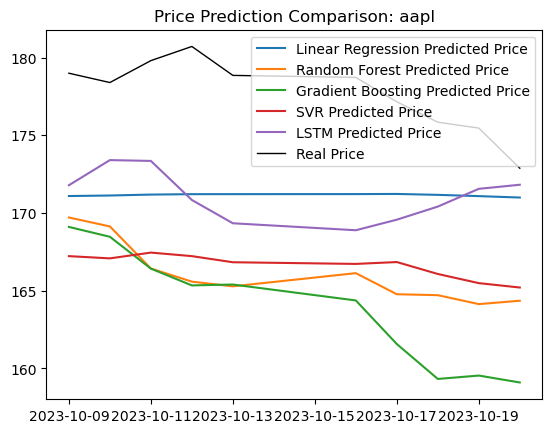

Real Prices: [178.99000549 178.38999939 179.80000305 180.71000671 178.8500061
 178.72000122 177.1499939  175.83999634 175.46000671 172.88000488]
Linear Regression Predicted Prices: [171.08939707 171.12397296 171.1830571  171.20968713 171.21125636
 171.21466927 171.2239694  171.16603036 171.08402076 170.99338341]
Random Forest Predicted Prices: [169.70947655 169.13411011 166.42802223 165.58341156 165.28154388
 166.12898827 164.77259575 164.71281342 164.13839905 164.35430107]
Gradient Boosting Predicted Prices: [169.1035901  168.46877424 166.42104221 165.34108911 165.39765832
 164.37355129 161.56898455 159.32416685 159.54172574 159.09693801]
SVR Predicted Prices: [167.2240363  167.08005758 167.45223599 167.22425344 166.8307847
 166.72355304 166.84315854 166.07583137 165.48740941 165.20516467]
LSTM Predicted Prices: [171.7837267  173.40103842 173.34825183 170.8345537  169.33829058
 168.88945292 169.56893917 170.41157861 171.5533898  171.81537675]


In [31]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime

def compute_rsi(data, window):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = up.rolling(window=window).mean()
    roll_down = down.abs().rolling(window=window).mean()
    
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    
    return RSI

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# 下载股票数据
ticker_symbol = 'aapl'
ticker_data = yf.Ticker(ticker_symbol)
start_date = '2020-01-01'
end_date = '2023-10-01'
historical_data = ticker_data.history(start=start_date, end=end_date)
data = historical_data[['Close', 'Volume']].copy()

# 添加技术指标
data.loc[:, 'RSI'] = compute_rsi(data['Close'], 14)
data.loc[:, 'SMA'] = data['Close'].rolling(window=5).mean()
data.dropna(inplace=True)

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 使用滑动窗口法创建数据集
look_back = 10
X, y = create_dataset(data_scaled, look_back)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# 创建和训练模型
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=24),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=24),
    "SVR": SVR(kernel='rbf', C=1e3, gamma=0.1),
    "LSTM": Sequential([
        LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(25),
        Dense(1)
    ])
}
models["LSTM"].compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
models["Linear Regression"].fit(X_train[:, -1, :], y_train)
models["Random Forest"].fit(X_train[:, -1, :], y_train)
models["Gradient Boosting"].fit(X_train[:, -1, :], y_train)
models["SVR"].fit(X_train[:, -1, :], y_train)
models["LSTM"].fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), verbose=1, shuffle=False)

# 获取真实的股价数据
real_data = ticker_data.history(start='2023-10-09', end=datetime.today().strftime('%Y-%m-%d'))
real_prices = real_data['Close'].values
num_points = min(len(real_prices), 10)
def predict_future(model, initial_input, steps, is_lstm=False):
    future_predictions = []
    current_input = initial_input.copy()
    
    for i in range(steps):
        if is_lstm:
            current_prediction = model.predict(current_input[np.newaxis, :, :])[0, 0]
            future_predictions.append(current_prediction)
            current_input = np.roll(current_input, -1, axis=0)
            current_input[-1, 0] = current_prediction
        else:
            current_prediction = model.predict(current_input[-1, :].reshape(1, -1))
            future_predictions.append(current_prediction[0])
            current_input = np.roll(current_input, -1, axis=0)
            current_input[-1, 0] = current_prediction[0]
    
    return future_predictions

# 预测股价
predictions = {}
for model_name, model in models.items():
    if model_name == "LSTM":
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=True)
    else:
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=False)
    
    predicted_prices = scaler.inverse_transform(np.hstack([np.array(predictions[model_name]).reshape(-1, 1), np.zeros((len(predictions[model_name]), data.shape[1]-1))]))[:, 0]
    plt.plot(real_data.index[:num_points], predicted_prices, label=f'{model_name} Predicted Price')

# 绘制真实股价
plt.plot(real_data.index[:num_points], real_prices[:num_points], label='Real Price', color='black', linewidth=1)
plt.legend()
plt.title(f'Price Prediction Comparison: {ticker_symbol}')
plt.show()

# 打印真实价格和预测价格
print(f"Real Prices: {real_prices[:num_points]}")
for model_name, prediction in predictions.items():
    predicted_prices = scaler.inverse_transform(np.hstack([np.array(prediction).reshape(-1, 1), np.zeros((len(prediction), data.shape[1]-1))]))[:, 0]
    print(f"{model_name} Predicted Prices: {predicted_prices}")


In [ ]:
def compute_bollinger_bands(data, window):
    sma = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = sma + (rolling_std*2)
    lower_band = sma - (rolling_std*2)
    
    return upper_band, lower_band

# 添加布林带特征
data['Upper_Band'], data['Lower_Band'] = compute_bollinger_bands(data, 20)
data.dropna(inplace=True)

# 重新进行数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 使用滑动窗口法创建新数据集
X, y = create_dataset(data_scaled, look_back)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# 重新训练模型
models["Linear Regression"].fit(X_train[:, -1, :], y_train)
models["Random Forest"].fit(X_train[:, -1, :], y_train)
models["Gradient Boosting"].fit(X_train[:, -1, :], y_train)
models["SVR"].fit(X_train[:, -1, :], y_train)

# LSTM模型可能需要重新初始化，以防止之前的权重影响结果
models["LSTM"] = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(25),
    Dense(1)
])
models["LSTM"].compile(optimizer='adam', loss='mean_squared_error')
models["LSTM"].fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), verbose=1, shuffle=False)

# 预测股价
predictions = {}
for model_name, model in models.items():
    if model_name == "LSTM":
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=True)
    else:
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=False)
    
    predicted_prices = scaler.inverse_transform(np.hstack([np.array(predictions[model_name]).reshape(-1, 1), np.zeros((len(predictions[model_name]), data.shape[1]-1))]))[:, 0]
    plt.plot(real_data.index[:num_points], predicted_prices, label=f'{model_name} Predicted Price')

# 绘制真实股价
plt.plot(real_data.index[:num_points], real_prices[:num_points], label='Real Price', color='black', linewidth=1)
plt.legend()
plt.title(f'Price Prediction Comparison with Bollinger Bands: {ticker_symbol}')
plt.show()

# 打印真实价格和预测价格
real_prices_output = real_prices[:num_points]
predicted_prices_output = {}
for model_name, prediction in predictions.items():
    predicted_prices_output[model_name] = scaler.inverse_transform(np.hstack([np.array(prediction).reshape(-1, 1), np.zeros((len(prediction), data.shape[1]-1))]))[:, 0]

real_prices_output, predicted_prices_output

Epoch 1/50
13/13 [==============================] - 5s 76ms/step - loss: 0.0653 - val_loss: 0.0223
Epoch 2/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0460 - val_loss: 0.0169
Epoch 3/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0329 - val_loss: 0.0158
Epoch 4/50
13/13 [==============================] - 0s 22ms/step - loss: 0.0286 - val_loss: 0.0183
Epoch 5/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0297 - val_loss: 0.0152
Epoch 6/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0277 - val_loss: 0.0163
Epoch 7/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0274 - val_loss: 0.0161
Epoch 8/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0260 - val_loss: 0.0157
Epoch 9/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0274 - val_loss: 0.0170
Epoch 10/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0264 - val_loss: 0.0143
Epoch 11/

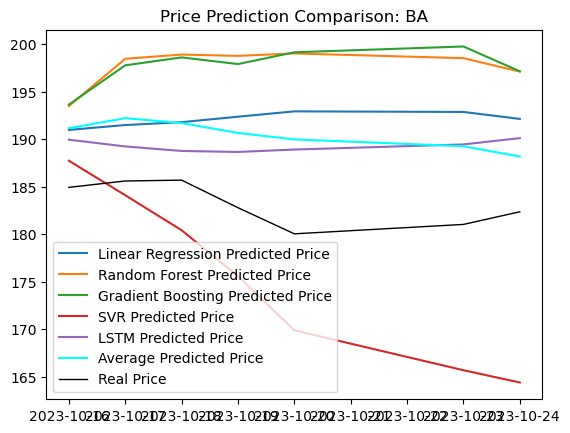

Real Prices: [184.92999268 185.6000061  185.69000244 182.78999329 180.03999329
 181.02999878 182.36000061]
Linear Regression Predicted Prices: [0.01125581153278618, 0.021847021851026723, 0.02810656355369863, 0.03996405103823568, 0.05159222959658977, 0.05028902429109683, 0.03517054672130554]
Random Forest Predicted Prices: [0.06307936900103171, 0.16588403575635596, 0.1749794501165048, 0.1721644816330491, 0.17746603644082676, 0.16714384981473251, 0.13805671087155333]
Gradient Boosting Predicted Prices: [0.06638795928099628, 0.1516158257845179, 0.16883952055446125, 0.15434840288510973, 0.17995588497821718, 0.19257906917419074, 0.13861159497379952]
SVR Predicted Prices: [-0.05574424539485434, -0.13068799341976145, -0.206798858122048, -0.3065636745931134, -0.4243207966284136, -0.5110193300667935, -0.5376242267305916]
LSTM Predicted Prices: [-0.010058837, -0.02462929, -0.034466535, -0.036664724, -0.031421192, -0.020279972, -0.0066063143]
Average Predicted Prices: [191.15551871 192.21213582 1

C:\Users\jizha\AppData\Local\Temp\ipykernel_15120\1937805002.py:143: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  random_dates = random.sample(list(historical_data['2023'].index), 5)


1/1 [==============================] - 0s 16ms/step
Average MAPE for each model over 5 random periods:
Linear Regression: 12.16%
Random Forest: 9.72%
Gradient Boosting: 9.73%
SVR: 20.38%
LSTM: 13.31%

The best model based on the average MAPE over 5 random periods is: Random Forest with an average error of 9.72%.


In [45]:
 import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime

def compute_rsi(data, window):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = up.rolling(window=window).mean()
    roll_down = down.abs().rolling(window=window).mean()
    
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    
    return RSI

def compute_bollinger_bands(data, window):
    sma = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = sma + (rolling_std*2)
    lower_band = sma - (rolling_std*2)
    
    return upper_band, lower_band

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

ticker_symbol = 'BA'
ticker_data = yf.Ticker(ticker_symbol)
start_date = '2023-01-01'
end_date = '2023-10-01'
historical_data = ticker_data.history(start=start_date, end=end_date)
data = historical_data[['Close', 'Volume']].copy()
#{'RSI_window': 20, 'SMA_window': 9, 'Bollinger_window': 23}

# 添加技术指标
data['RSI'] = compute_rsi(data['Close'], 20)
data['SMA'] = data['Close'].rolling(window=9).mean()
data['Upper_Band'], data['Lower_Band'] = compute_bollinger_bands(data, 23)
data.dropna(inplace=True)

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 使用滑动窗口法创建数据集
look_back = 10
X, y = create_dataset(data_scaled, look_back)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=12),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=12),
    "SVR": SVR(kernel='rbf', C=1e3, gamma=0.1),
    "LSTM": Sequential([
        LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(25),
        Dense(1)
    ])
}

models["LSTM"].compile(optimizer='adam', loss='mean_squared_error')
models["Linear Regression"].fit(X_train[:, -1, :], y_train)
models["Random Forest"].fit(X_train[:, -1, :], y_train)
models["Gradient Boosting"].fit(X_train[:, -1, :], y_train)
models["SVR"].fit(X_train[:, -1, :], y_train)
models["LSTM"].fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), verbose=1, shuffle=False)

real_data = ticker_data.history(start='2023-10-16', end=datetime.today().strftime('%Y-%m-%d'))
real_prices = real_data['Close'].values
num_points = min(len(real_prices), 10)

def predict_future(model, initial_input, steps, is_lstm=False):
    future_predictions = []
    current_input = initial_input.copy()
    
    for i in range(steps):
        if is_lstm:
            current_prediction = model.predict(current_input[np.newaxis, :, :])[0, 0]
            future_predictions.append(current_prediction)
            current_input = np.roll(current_input, -1, axis=0)
            current_input[-1, 0] = current_prediction
        else:
            current_prediction = model.predict(current_input[-1, :].reshape(1, -1))
            future_predictions.append(current_prediction[0])
            current_input = np.roll(current_input, -1, axis=0)
            current_input[-1, 0] = current_prediction[0]
    
    return future_predictions
 # 获取每个模型的预测结果
all_predictions = []

for model_name, model in models.items():
    if model_name == "LSTM":
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=True)
    else:
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=False)
    
    predicted_prices = scaler.inverse_transform(np.hstack([np.array(predictions[model_name]).reshape(-1, 1), np.zeros((len(predictions[model_name]), data.shape[1]-1))]))[:, 0]
    all_predictions.append(predicted_prices)
    plt.plot(real_data.index[:num_points], predicted_prices, label=f'{model_name} Predicted Price')

# 计算平均预测值
average_prediction = np.mean(all_predictions, axis=0)
predictions["Average"] = average_prediction
plt.plot(real_data.index[:num_points], average_prediction, label='Average Predicted Price', color='cyan', linewidth=1.5)

plt.plot(real_data.index[:num_points], real_prices[:num_points], label='Real Price', color='black', linewidth=1)
plt.legend()
plt.title(f'Price Prediction Comparison: {ticker_symbol}')
plt.show()

print(f"Real Prices: {real_prices[:num_points]}")
for model_name, prediction in predictions.items():
    if model_name in models or model_name == "Average":
        print(f"{model_name} Predicted Prices: {prediction}")
import random

# 定义函数计算预测误差
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 从2023年随机选择5个10日时间段
random_dates = random.sample(list(historical_data['2023'].index), 5)

model_errors = {}

for start_date in random_dates:
    end_date = start_date + pd.Timedelta(days=10)
    
    real_data = ticker_data.history(start=start_date, end=end_date)
    real_prices = real_data['Close'].values
    num_points = len(real_prices)
    
    for model_name, model in models.items():
        if model_name == "LSTM":
            predicted = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=True)
        else:
            predicted = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=False)
        
        predicted_prices = scaler.inverse_transform(np.hstack([np.array(predicted).reshape(-1, 1), np.zeros((len(predicted), data.shape[1]-1))]))[:, 0]
        error = mean_absolute_percentage_error(real_prices, predicted_prices)
        
        if model_name not in model_errors:
            model_errors[model_name] = []
        model_errors[model_name].append(error)

avg_errors = {model_name: np.mean(errors) for model_name, errors in model_errors.items()}
best_model_name = min(avg_errors, key=avg_errors.get)

print(f"Average MAPE for each model over 5 random periods:")
for model_name, error in avg_errors.items():
    print(f"{model_name}: {error:.2f}%")
    
print(f"\nThe best model based on the average MAPE over 5 random periods is: {best_model_name} with an average error of {avg_errors[best_model_name]:.2f}%.")


In [48]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# 定义技术指标参数的搜索空间
space = [
    Integer(5, 20, name='RSI_window'),
    Integer(3, 10, name='SMA_window'),
    Integer(10, 30, name='Bollinger_window')
]

# 定义基于技术指标参数的目标函数
@use_named_args(space)
def objective(**params):
    # 使用参数更新技术指标
    data['RSI'] = compute_rsi(data['Close'], params['RSI_window'])
    data['SMA'] = data['Close'].rolling(window=params['SMA_window']).mean()
    data['Upper_Band'], data['Lower_Band'] = compute_bollinger_bands(data, params['Bollinger_window'])
    
    # 删除NaN值
    data_temp = data.dropna()
    
    # 数据归一化
    scaler_temp = MinMaxScaler(feature_range=(0, 1))
    data_scaled_temp = scaler_temp.fit_transform(data_temp)
    
    # 创建数据集
    X_temp, y_temp = create_dataset(data_scaled_temp, look_back)
    
    # 切分数据集
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y_temp, test_size=0.2, random_state=12)
    
    # 使用某个模型（例如随机森林）进行预测
    model_temp = RandomForestRegressor(n_estimators=100, random_state=12)
    model_temp.fit(X_train_temp[:, -1, :], y_train_temp)
    predictions_temp = model_temp.predict(X_test_temp[:, -1, :])
    
    # 计算MAPE作为目标函数的值
    mape = mean_absolute_percentage_error(y_test_temp, predictions_temp)
    return mape

# 使用贝叶斯优化进行优化
res = gp_minimize(objective, space, n_calls=50, random_state=12)

best_params = {
    "RSI_window": res.x[0],
    "SMA_window": res.x[1],
    "Bollinger_window": res.x[2]
}
best_params

B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at thi

{'RSI_window': 20, 'SMA_window': 9, 'Bollinger_window': 23}

Epoch 1/50
13/13 [==============================] - 5s 95ms/step - loss: 0.0681 - val_loss: 0.0155
Epoch 2/50
13/13 [==============================] - 0s 12ms/step - loss: 0.0217 - val_loss: 0.0088
Epoch 3/50
13/13 [==============================] - 0s 11ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 4/50
13/13 [==============================] - 0s 12ms/step - loss: 0.0077 - val_loss: 0.0082
Epoch 5/50
13/13 [==============================] - 0s 12ms/step - loss: 0.0086 - val_loss: 0.0077
Epoch 6/50
13/13 [==============================] - 0s 12ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 7/50
13/13 [==============================] - 0s 13ms/step - loss: 0.0070 - val_loss: 0.0063
Epoch 8/50
13/13 [==============================] - 0s 12ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 9/50
13/13 [==============================] - 0s 12ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 10/50
13/13 [==============================] - 0s 12ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 11/

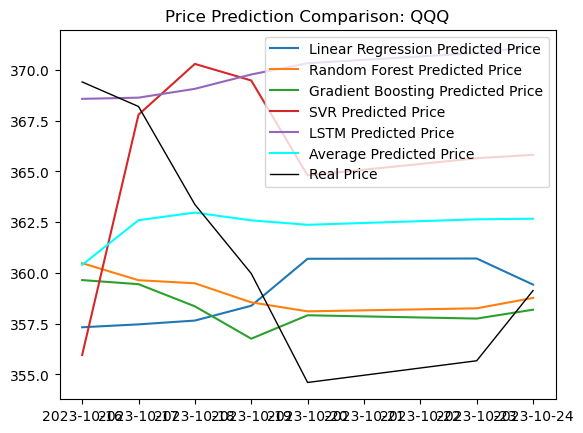

Real Prices: [369.41000366 368.20001221 363.36999512 359.97000122 354.6000061
 355.67001343 359.13000488]
Linear Regression Predicted Prices: [0.7153758081113758, 0.7168373988583431, 0.7187446753235316, 0.7261974919665071, 0.7498549883731183, 0.7499906206048025, 0.7368440321805829]
Random Forest Predicted Prices: [0.7476427231986287, 0.7390599524570359, 0.7375134873933206, 0.7279168169595883, 0.7233874283932812, 0.724918710884221, 0.7301356922957014]
Gradient Boosting Predicted Prices: [0.7391252546108958, 0.7370645386672273, 0.7259206695648436, 0.7096205868247071, 0.7214080845178683, 0.719747363324633, 0.724216625774351]
SVR Predicted Prices: [0.7013967595515718, 0.822408080204241, 0.8479485887123075, 0.8396149986331625, 0.7918147662283062, 0.8004779769079355, 0.8021574245736733]
LSTM Predicted Prices: [0.83035475, 0.8309633, 0.8354035, 0.84262896, 0.8482917, 0.85339874, 0.8567235]
Average Predicted Prices: [360.39487242 362.59615966 362.972007   362.58922064 362.36952089
 362.6392333

C:\Users\jizha\AppData\Local\Temp\ipykernel_15120\661363706.py:144: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  random_dates = random.sample(list(historical_data['2023'].index), 5)


1/1 [==============================] - 0s 18ms/step
Average MAPE for each model over 5 random periods:
Linear Regression: 5.93%
Random Forest: 5.96%
Gradient Boosting: 5.98%
SVR: 6.00%
LSTM: 6.27%

The best model based on the average MAPE over 5 random periods is: Linear Regression with an average error of 5.93%.


In [55]:
 import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime

def compute_rsi(data, window):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = up.rolling(window=window).mean()
    roll_down = down.abs().rolling(window=window).mean()
    
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    
    return RSI

def compute_bollinger_bands(data, window):
    sma = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = sma + (rolling_std*2)
    lower_band = sma - (rolling_std*2)
    
    return upper_band, lower_band

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

ticker_symbol = 'QQQ'
ticker_data = yf.Ticker(ticker_symbol)
start_date = '2023-01-01'
end_date = '2023-10-01'
historical_data = ticker_data.history(start=start_date, end=end_date)
data = historical_data[['Close', 'Volume']].copy()
#{'RSI_window': 20, 'SMA_window': 9, 'Bollinger_window': 23}

# 添加技术指标
data['RSI'] = compute_rsi(data['Close'], 20)
data['SMA'] = data['Close'].rolling(window=9).mean()
data['Upper_Band'], data['Lower_Band'] = compute_bollinger_bands(data, 23)
data.dropna(inplace=True)

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 使用滑动窗口法创建数据集
look_back = 10
X, y = create_dataset(data_scaled, look_back)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=12),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=12),
    "SVR": SVR(kernel='rbf', C=1e3, gamma=0.1),
    "LSTM": Sequential([
        LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(25),
        Dense(1)
    ])
}

models["LSTM"].compile(optimizer='adam', loss='mean_squared_error')
models["Linear Regression"].fit(X_train[:, -1, :], y_train)
models["Random Forest"].fit(X_train[:, -1, :], y_train)
models["Gradient Boosting"].fit(X_train[:, -1, :], y_train)
models["SVR"].fit(X_train[:, -1, :], y_train)
models["LSTM"].fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), verbose=1, shuffle=False)

real_data = ticker_data.history(start='2023-10-16', end=datetime.today().strftime('%Y-%m-%d'))
real_prices = real_data['Close'].values
num_points = min(len(real_prices), 10)

def predict_future(model, initial_input, steps, is_lstm=False):
    future_predictions = []
    current_input = initial_input.copy()
    
    for i in range(steps):
        if is_lstm:
            current_prediction = model.predict(current_input[np.newaxis, :, :])[0, 0]
            future_predictions.append(current_prediction)
            current_input = np.roll(current_input, -1, axis=0)
            current_input[-1, 0] = current_prediction
        else:
            current_prediction = model.predict(current_input[-1, :].reshape(1, -1))
            future_predictions.append(current_prediction[0])
            current_input = np.roll(current_input, -1, axis=0)
            current_input[-1, 0] = current_prediction[0]
    
    return future_predictions
 # 获取每个模型的预测结果
all_predictions = []

for model_name, model in models.items():
    if model_name == "LSTM":
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=True)
    else:
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=False)
    
    predicted_prices = scaler.inverse_transform(np.hstack([np.array(predictions[model_name]).reshape(-1, 1), np.zeros((len(predictions[model_name]), data.shape[1]-1))]))[:, 0]
    all_predictions.append(predicted_prices)
    plt.plot(real_data.index[:num_points], predicted_prices, label=f'{model_name} Predicted Price')

# 计算平均预测值
average_prediction = np.mean(all_predictions, axis=0)
predictions["Average"] = average_prediction
plt.plot(real_data.index[:num_points], average_prediction, label='Average Predicted Price', color='cyan', linewidth=1.5)

plt.plot(real_data.index[:num_points], real_prices[:num_points], label='Real Price', color='black', linewidth=1)
plt.legend()
plt.title(f'Price Prediction Comparison: {ticker_symbol}')
plt.show()

print(f"Real Prices: {real_prices[:num_points]}")
for model_name, prediction in predictions.items():
    if model_name in models or model_name == "Average":
        print(f"{model_name} Predicted Prices: {prediction}")
import random

# 定义函数计算预测误差
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 从2023年随机选择5个10日时间段
random_dates = random.sample(list(historical_data['2023'].index), 5)

model_errors = {}

for start_date in random_dates:
    end_date = start_date + pd.Timedelta(days=10)
    
    real_data = ticker_data.history(start=start_date, end=end_date)
    real_prices = real_data['Close'].values
    num_points = len(real_prices)
    
    for model_name, model in models.items():
        if model_name == "LSTM":
            predicted = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=True)
        else:
            predicted = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=False)
        
        predicted_prices = scaler.inverse_transform(np.hstack([np.array(predicted).reshape(-1, 1), np.zeros((len(predicted), data.shape[1]-1))]))[:, 0]
        error = mean_absolute_percentage_error(real_prices, predicted_prices)
        
        if model_name not in model_errors:
            model_errors[model_name] = []
        model_errors[model_name].append(error)

avg_errors = {model_name: np.mean(errors) for model_name, errors in model_errors.items()}
best_model_name = min(avg_errors, key=avg_errors.get)

print(f"Average MAPE for each model over 5 random periods:")
for model_name, error in avg_errors.items():
    print(f"{model_name}: {error:.2f}%")
    
print(f"\nThe best model based on the average MAPE over 5 random periods is: {best_model_name} with an average error of {avg_errors[best_model_name]:.2f}%.")


In [62]:
 import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime

def compute_rsi(data, window):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = up.rolling(window=window).mean()
    roll_down = down.abs().rolling(window=window).mean()
    
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    
    return RSI

def compute_bollinger_bands(data, window):
    sma = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = sma + (rolling_std*2)
    lower_band = sma - (rolling_std*2)
    
    return upper_band, lower_band

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

 
ticker_symbol = 'QQQ'
ticker_data = yf.Ticker(ticker_symbol)
start_date = '2023-01-01'
end_date = '2023-10-01'
historical_data = ticker_data.history(start=start_date, end=end_date)
data = historical_data[['Close', 'Volume']].copy()
#{'RSI_window': 20, 'SMA_window': 9, 'Bollinger_window': 23}

# 评估函数
def evaluate_parameters(rsi_window, sma_window, bollinger_window):
    data = get_data('QQQ', '2023-01-01', '2023-10-01')
    
    data['RSI'] = compute_rsi(data['Close'], rsi_window)
    data['SMA'] = data['Close'].rolling(window=sma_window).mean()
    data['Upper_Band'], data['Lower_Band'] = compute_bollinger_bands(data, bollinger_window)
    
    data.dropna(inplace=True)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    
    look_back = 10
    X, y = create_dataset(data_scaled, look_back)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    
    model = LinearRegression()
    model.fit(X_train[:, -1, :], y_train)
    y_pred = model.predict(X_test[:, -1, :])
    y_real = y_test
    
    mape = mean_absolute_percentage_error(y_real, y_pred)
    
    return mape
# 定义搜索空间
space  = [Integer(5, 20, name='rsi_window'),
          Integer(3, 15, name='sma_window'),
          Integer(10, 30, name='bollinger_window')]
# 使用贝叶斯优化
@use_named_args(space)
def objective(**params):
    return evaluate_parameters(params['rsi_window'], params['sma_window'], params['bollinger_window'])
res = gp_minimize(objective, space, n_calls=50, random_state=0)
# 获取最佳参数
best_rsi_window = res.x[0]
best_sma_window = res.x[1]
best_bollinger_window = res.x[2]
#  输出最佳参数
print("Best parameters:")
print("RSI window:", res.x[0])
print("SMA window:", res.x[1])
print("Bollinger Bands window:", res.x[2])
# 添加技术指标
data['RSI'] = compute_rsi(data['Close'], 13)
data['SMA'] = data['Close'].rolling(window=10).mean()
data['Upper_Band'], data['Lower_Band'] = compute_bollinger_bands(data, 29)
data.dropna(inplace=True)

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 使用滑动窗口法创建数据集
look_back = 10
X, y = create_dataset(data_scaled, look_back)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=12),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=12),
    "SVR": SVR(kernel='rbf', C=1e3, gamma=0.1),
    "LSTM": Sequential([
        LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(25),
        Dense(1)
    ])
}

models["LSTM"].compile(optimizer='adam', loss='mean_squared_error')
models["Linear Regression"].fit(X_train[:, -1, :], y_train)
models["Random Forest"].fit(X_train[:, -1, :], y_train)
models["Gradient Boosting"].fit(X_train[:, -1, :], y_train)
models["SVR"].fit(X_train[:, -1, :], y_train)
models["LSTM"].fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), verbose=1, shuffle=False)

real_data = ticker_data.history(start='2023-10-16', end=datetime.today().strftime('%Y-%m-%d'))
real_prices = real_data['Close'].values
num_points = min(len(real_prices), 10)

def predict_future(model, initial_input, steps, is_lstm=False):
    future_predictions = []
    current_input = initial_input.copy()
    
    for i in range(steps):
        if is_lstm:
            current_prediction = model.predict(current_input[np.newaxis, :, :])[0, 0]
            future_predictions.append(current_prediction)
            current_input = np.roll(current_input, -1, axis=0)
            current_input[-1, 0] = current_prediction
        else:
            current_prediction = model.predict(current_input[-1, :].reshape(1, -1))
            future_predictions.append(current_prediction[0])
            current_input = np.roll(current_input, -1, axis=0)
            current_input[-1, 0] = current_prediction[0]
    
    return future_predictions
 # 获取每个模型的预测结果
all_predictions = []

for model_name, model in models.items():
    if model_name == "LSTM":
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=True)
    else:
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=False)
    
    predicted_prices = scaler.inverse_transform(np.hstack([np.array(predictions[model_name]).reshape(-1, 1), np.zeros((len(predictions[model_name]), data.shape[1]-1))]))[:, 0]
    all_predictions.append(predicted_prices)
    plt.plot(real_data.index[:num_points], predicted_prices, label=f'{model_name} Predicted Price')

# 计算平均预测值
average_prediction = np.mean(all_predictions, axis=0)
predictions["Average"] = average_prediction
plt.plot(real_data.index[:num_points], average_prediction, label='Average Predicted Price', color='cyan', linewidth=1.5)

plt.plot(real_data.index[:num_points], real_prices[:num_points], label='Real Price', color='black', linewidth=1)
plt.legend()
plt.title(f'Price Prediction Comparison: {ticker_symbol}')
plt.show()

print(f"Real Prices: {real_prices[:num_points]}")
for model_name, prediction in predictions.items():
    if model_name in models or model_name == "Average":
        print(f"{model_name} Predicted Prices: {prediction}")
import random

# 定义函数计算预测误差
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 从2023年随机选择5个10日时间段
random_dates = random.sample(list(historical_data['2023'].index), 5)

model_errors = {}

for start_date in random_dates:
    end_date = start_date + pd.Timedelta(days=10)
    
    real_data = ticker_data.history(start=start_date, end=end_date)
    real_prices = real_data['Close'].values
    num_points = len(real_prices)
    
    for model_name, model in models.items():
        if model_name == "LSTM":
            predicted = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=True)
        else:
            predicted = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=False)
        
        predicted_prices = scaler.inverse_transform(np.hstack([np.array(predicted).reshape(-1, 1), np.zeros((len(predicted), data.shape[1]-1))]))[:, 0]
        error = mean_absolute_percentage_error(real_prices, predicted_prices)
        
        if model_name not in model_errors:
            model_errors[model_name] = []
        model_errors[model_name].append(error)

avg_errors = {model_name: np.mean(errors) for model_name, errors in model_errors.items()}
best_model_name = min(avg_errors, key=avg_errors.get)

print(f"Average MAPE for each model over 5 random periods:")
for model_name, error in avg_errors.items():
    print(f"{model_name}: {error:.2f}%")
    
print(f"\nThe best model based on the average MAPE over 5 random periods is: {best_model_name} with an average error of {avg_errors[best_model_name]:.2f}%.")


C:\Users\jizha\AppData\Local\Temp\ipykernel_15120\3514907845.py:141: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


ValueError: Input y contains infinity or a value too large for dtype('float64').

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime

def compute_rsi(data, window):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = up.rolling(window=window).mean()
    roll_down = down.abs().rolling(window=window).mean()
    
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    
    return RSI

def compute_bollinger_bands(data, window):
    sma = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = sma + (rolling_std*2)
    lower_band = sma - (rolling_std*2)
    
    return upper_band, lower_band

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


ticker_symbol = 'BA'
ticker_data = yf.Ticker(ticker_symbol)
start_date = '2023-01-01'
end_date = '2023-10-01'
historical_data = ticker_data.history(start=start_date, end=end_date)
data = historical_data[['Close', 'Volume']].copy()
#{'RSI_window': 20, 'SMA_window': 9, 'Bollinger_window': 23}
def objective(params):
    rsi_window, sma_window, bollinger_window = params
    
    data['RSI'] = compute_rsi(data['Close'], rsi_window)
    data['SMA'] = data['Close'].rolling(window=sma_window).mean()
    data['Upper_Band'], data['Lower_Band'] = compute_bollinger_bands(data, bollinger_window)
    data.dropna(inplace=True)

    # 数据归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    # 使用滑动窗口法创建数据集
    look_back = 10
    X, y = create_dataset(data_scaled, look_back)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

    total_error = 0
    for model_name, model in models.items():
        if model_name == "LSTM":
            model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=0, shuffle=False)
            y_pred = model.predict(X_test).flatten()
        else:
            model.fit(X_train[:, -1, :], y_train)
            y_pred = model.predict(X_test[:, -1, :])
        
        total_error += mean_squared_error(y_test, y_pred)

    # 返回所有模型的平均误差
    return total_error / len(models)


models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=12),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=12),
    "SVR": SVR(kernel='rbf', C=1e3, gamma=0.1),
    "LSTM": Sequential([
        LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(25),
        Dense(1)
    ])
}

models["LSTM"].compile(optimizer='adam', loss='mean_squared_error')
models["Linear Regression"].fit(X_train[:, -1, :], y_train)
models["Random Forest"].fit(X_train[:, -1, :], y_train)
models["Gradient Boosting"].fit(X_train[:, -1, :], y_train)
models["SVR"].fit(X_train[:, -1, :], y_train)
models["LSTM"].fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), verbose=1, shuffle=False)

real_data = ticker_data.history(start='2023-10-16', end=datetime.today().strftime('%Y-%m-%d'))
real_prices = real_data['Close'].values
num_points = min(len(real_prices), 10)

def predict_future(model, initial_input, steps, is_lstm=False):
    future_predictions = []
    current_input = initial_input.copy()
    
    for i in range(steps):
        if is_lstm:
            current_prediction = model.predict(current_input[np.newaxis, :, :])[0, 0]
            future_predictions.append(current_prediction)
            current_input = np.roll(current_input, -1, axis=0)
            current_input[-1, 0] = current_prediction
        else:
            current_prediction = model.predict(current_input[-1, :].reshape(1, -1))
            future_predictions.append(current_prediction[0])
            current_input = np.roll(current_input, -1, axis=0)
            current_input[-1, 0] = current_prediction[0]
    
    return future_predictions
 # 获取每个模型的预测结果
all_predictions = []

for model_name, model in models.items():
    if model_name == "LSTM":
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=True)
    else:
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=False)
    
    predicted_prices = scaler.inverse_transform(np.hstack([np.array(predictions[model_name]).reshape(-1, 1), np.zeros((len(predictions[model_name]), data.shape[1]-1))]))[:, 0]
    all_predictions.append(predicted_prices)
    plt.plot(real_data.index[:num_points], predicted_prices, label=f'{model_name} Predicted Price')

# 计算平均预测值
average_prediction = np.mean(all_predictions, axis=0)
predictions["Average"] = average_prediction
plt.plot(real_data.index[:num_points], average_prediction, label='Average Predicted Price', color='cyan', linewidth=1.5)

plt.plot(real_data.index[:num_points], real_prices[:num_points], label='Real Price', color='black', linewidth=1)
plt.legend()
plt.title(f'Price Prediction Comparison: {ticker_symbol}')
plt.show()

print(f"Real Prices: {real_prices[:num_points]}")
for model_name, prediction in predictions.items():
    if model_name in models or model_name == "Average":
        print(f"{model_name} Predicted Prices: {prediction}")
import random

# 定义函数计算预测误差
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 从2023年随机选择5个10日时间段
random_dates = random.sample(list(historical_data['2023'].index), 5)

model_errors = {}

for start_date in random_dates:
    end_date = start_date + pd.Timedelta(days=10)
    
    real_data = ticker_data.history(start=start_date, end=end_date)
    real_prices = real_data['Close'].values
    num_points = len(real_prices)
    
    for model_name, model in models.items():
        if model_name == "LSTM":
            predicted = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=True)
        else:
            predicted = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=False)
        
        predicted_prices = scaler.inverse_transform(np.hstack([np.array(predicted).reshape(-1, 1), np.zeros((len(predicted), data.shape[1]-1))]))[:, 0]
        error = mean_absolute_percentage_error(real_prices, predicted_prices)
        
        if model_name not in model_errors:
            model_errors[model_name] = []
        model_errors[model_name].append(error)

avg_errors = {model_name: np.mean(errors) for model_name, errors in model_errors.items()}
best_model_name = min(avg_errors, key=avg_errors.get)

print(f"Average MAPE for each model over 5 random periods:")
for model_name, error in avg_errors.items():
    print(f"{model_name}: {error:.2f}%")
    
print(f"\nThe best model based on the average MAPE over 5 random periods is: {best_model_name} with an average error of {avg_errors[best_model_name]:.2f}%.")
 

In [60]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# 提前定义的一些函数

def compute_rsi(data, window):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = up.rolling(window=window).mean()
    roll_down = down.abs().rolling(window=window).mean()
    
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    
    return RSI

def compute_bollinger_bands(data, window):
    sma = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = sma + (rolling_std*2)
    lower_band = sma - (rolling_std*2)
    
    return upper_band, lower_band

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def get_data(ticker_symbol, start_date, end_date):
    ticker_data = yf.Ticker(ticker_symbol)
    historical_data = ticker_data.history(start=start_date, end=end_date)
    return historical_data[['Close', 'Volume']].copy()
def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-10):
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

 
# 评估函数
def evaluate_parameters(rsi_window, sma_window, bollinger_window):
    data = get_data('QQQ', '2023-01-01', '2023-10-01')
    
    data['RSI'] = compute_rsi(data['Close'], rsi_window)
    data['SMA'] = data['Close'].rolling(window=sma_window).mean()
    data['Upper_Band'], data['Lower_Band'] = compute_bollinger_bands(data, bollinger_window)
    
    data.dropna(inplace=True)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    
    look_back = 10
    X, y = create_dataset(data_scaled, look_back)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    
    model = LinearRegression()
    model.fit(X_train[:, -1, :], y_train)
    y_pred = model.predict(X_test[:, -1, :])
    y_real = y_test
    
    mape = mean_absolute_percentage_error(y_real, y_pred)
    
    return mape


# 定义搜索空间
space  = [Integer(5, 20, name='rsi_window'),
          Integer(3, 15, name='sma_window'),
          Integer(10, 30, name='bollinger_window')]

# 使用贝叶斯优化
@use_named_args(space)
def objective(**params):
    return evaluate_parameters(params['rsi_window'], params['sma_window'], params['bollinger_window'])

res = gp_minimize(objective, space, n_calls=50, random_state=0)
# 获取最佳参数
best_rsi_window = res.x[0]
best_sma_window = res.x[1]
best_bollinger_window = res.x[2]
#  输出最佳参数
print("Best parameters:")
print("RSI window:", res.x[0])
print("SMA window:", res.x[1])
print("Bollinger Bands window:", res.x[2])

B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at thi

Best parameters:
RSI window: 13
SMA window: 10
Bollinger Bands window: 29
